\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan']) #, drop_first=True)
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
y_train.sum()/len(y_train)

0.11782377603908752

## (b) {-}

In [2]:
from sklearn.linear_model import LogisticRegression
import pickle

clf = LogisticRegression(penalty='none').fit(X_train, y_train)

with open('clf.pkl', 'wb') as f:
    pickle.dump(clf, f)

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

with open('clf.pkl', 'rb') as f:
    clf = pickle.load(f)
    
y_pred = clf.predict(X_test)
1 - accuracy_score(y_test, y_pred)

0.11548257372654158

## (c) {-}

In [4]:
y_pred = np.zeros_like(y_test)
1 - accuracy_score(y_test, y_pred)

0.11528150134048254

## (d) {-}

In [5]:
predict_proba_test = clf.predict_proba(X_test)[:, 1]
bestIdxSet = predict_proba_test.argsort()[-1000:]

y_select = y_test[bestIdxSet]
y_test.sum()/len(y_test), y_select.sum()/len(y_select)

(0.11528150134048257, 0.291)

## (e) {-}

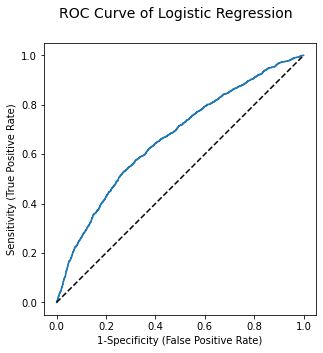

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from pandas import DataFrame

fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle('ROC Curve of Logistic Regression', fontsize=14)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set( aspect=1, 
        xlabel='1-Specificity (False Positive Rate)', 
        ylabel='Sensitivity (True Positive Rate)')
plt.show()

# 2. {-}

## (a) {-}

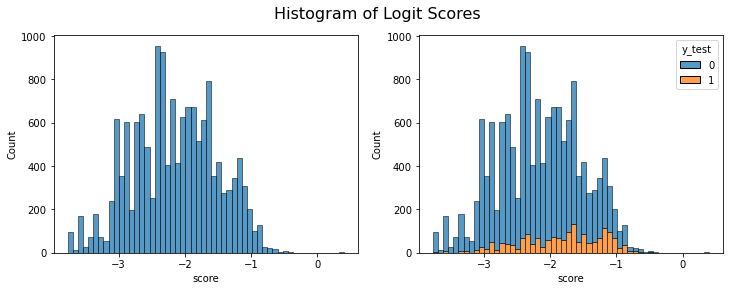

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

pn, pp = clf.predict_proba(X_test).T
scores = np.log(pp/pn)

df = DataFrame({'score': scores, 'y_test': y_test})

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(scores, ax=ax[0])
sns.histplot(x='score', hue='y_test', data=df, multiple='stack', ax=ax[1])
ax[0].set(xlabel='score')
plt.suptitle('Histogram of Logit Scores', fontsize=16)
plt.show()

## (b) {-}

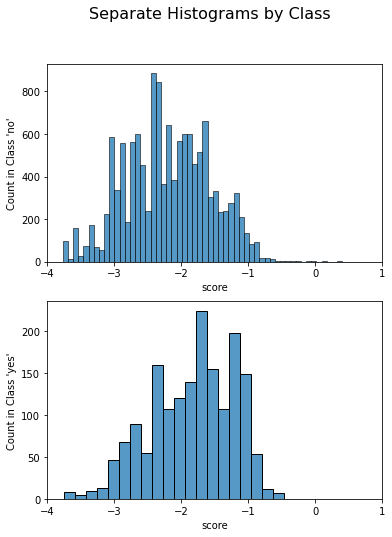

In [52]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sns.histplot(x='score', data=df[df['y_test']==0], ax=ax[0])
sns.histplot(x='score', data=df[df['y_test']==1], ax=ax[1])
ax[0].set(xlim=(-4, 1), ylabel="Count in Class 'no'")
ax[1].set(xlim=(-4, 1), ylabel="Count in Class 'yes'")
plt.suptitle('Separate Histograms by Class', fontsize=16)
plt.show()